## Deep lrarning for sentiment analysis

In [55]:
import pandas as pd 
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Master\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
df = pd.read_csv("IMDB_DATASET.csv")

In [57]:
df.head()

,Unnamed: 0,review,label,preprocessed_review
0,0,Bromwell High is a cartoon comedy. It ran at t...,1,bromwell high cartoon comedy ran time program ...
1,1,I liked the film. Some of the action scenes we...,1,liked film action scene interesting tense well...
2,2,Somewhat funny and well-paced action thriller ...,1,somewhat funny well paced action thriller jami...
3,3,Just two comments....SEVEN years apart? Hardly...,1,two comment seven year apart hardly evidence f...
4,4,"Another Aussie masterpiece, this delves into t...",1,another aussie masterpiece delf world unknown ...


In [58]:
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['label'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)
#we are using parameter stratify, to have an equal proportion of classes in train and test.

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (30450, 3) (30450,)
Test data: (13051, 3) (13051,)


# Putting all the text_preprocessing pipeline together:

In [59]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [60]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
  

In [61]:
trn_texts = normalize_corpus(X_train['preprocessed_review'])
tst_texts = normalize_corpus(X_test['preprocessed_review'])

## BoW

### Binary features


We will use the tokenizer of keras

In [62]:
# Fit the tokenizer

# Either pre-define vocab size
# Or get the max possible vocab from text
vocab_sz = 10000 # None means all
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
#tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index) # If all possible vocab, else, it's the predefine vocab_sz. Remember we cannot always use the len(tok.word_index), since it's always the max.

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')


In [63]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(30450, 10000)
(30450,)
(13051, 10000)
(13051,)


## Building our network

Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`
The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`
There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

and the final layer will use a sigmoid activation so as to output a probability 


Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

In [64]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                160016    
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [65]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

C:\Users\Master\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [66]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [67]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
40/40 [==============================] - 16s 111ms/step - loss: 0.4640 - binary_accuracy: 0.8178 - val_loss: 0.3345 - val_binary_accuracy: 0.8880
Epoch 2/20
40/40 [==============================] - 1s 28ms/step - loss: 0.2738 - binary_accuracy: 0.9048 - val_loss: 0.2750 - val_binary_accuracy: 0.8938
Epoch 3/20
40/40 [==============================] - 1s 37ms/step - loss: 0.2090 - binary_accuracy: 0.9245 - val_loss: 0.2646 - val_binary_accuracy: 0.8952
Epoch 4/20
40/40 [==============================] - 1s 24ms/step - loss: 0.1713 - binary_accuracy: 0.9393 - val_loss: 0.2729 - val_binary_accuracy: 0.8905
Epoch 5/20
40/40 [==============================] - 1s 22ms/step - loss: 0.1459 - binary_accuracy: 0.9483 - val_loss: 0.2939 - val_binary_accuracy: 0.8880
Epoch 6/20
40/40 [==============================] - 1s 20ms/step - loss: 0.1242 - binary_accuracy: 0.9574 - val_loss: 0.3093 - val_binary_accuracy: 0.8849
Epoch 7/20
40/40 [==============================] - 1s 22ms/step - l

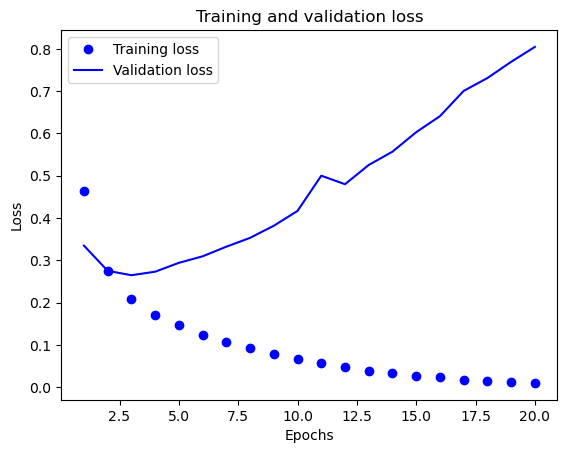

In [68]:
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

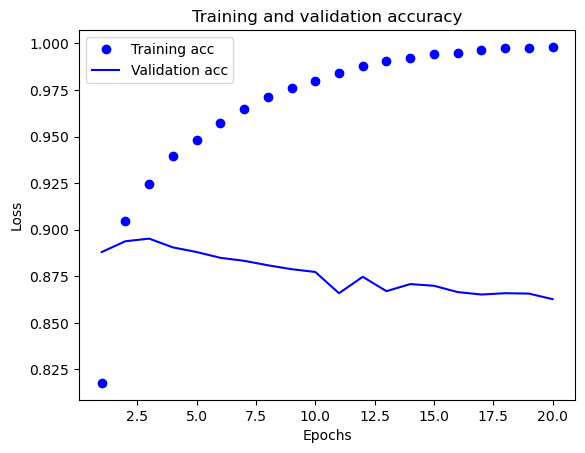

In [69]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### This is screanshot from Dr.ahmed el salab course (deep learning for NLP)

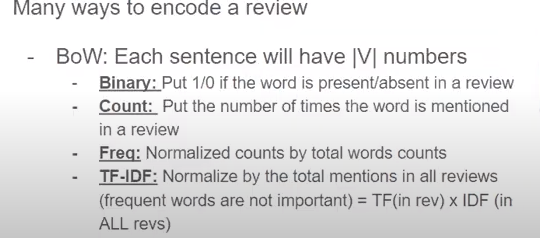

#### so let's try yhr other ways 

## Count

In [70]:
'''
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
'''
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='count')
x_test = tok.texts_to_matrix(tst_texts, mode='count')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)


In [71]:

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(18270, 10000)
(18270,)
(13051, 10000)
(13051,)


In [72]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Epoch 1/20
22/22 [==============================] - 4s 63ms/step - loss: 0.5623 - binary_accuracy: 0.7428 - val_loss: 0.4427 - val_binary_accuracy: 0.8651
Epoch 2/20
22/22 [==============================] - 0s 22ms/step - loss: 0.3573 - binary_accuracy: 0.8968 - val_loss: 0.3671 - val_binary_accuracy: 0.8664
Epoch 3/20
22/22 [==============================] - 0s 22ms/step - loss: 0.2616 - binary_accuracy: 0.9234 - val_loss: 0.3166 - val_binary_accuracy: 0.8838
Epoch 4/20
22/22 [==============================] - 0s 22ms/step - loss: 0.2023 - binary_accuracy: 0.9404 - val_loss: 0.3103 - val_binary_accuracy: 0.8801
Epoch 5/20
22/22 [==============================] - 1s 24ms/step - loss: 0.1607 - binary_accuracy: 0.9538 - val_loss: 0.3049 - val_binary_accuracy: 0.8830
Epoch 6/20
22/22 [==============================] - 0s 22ms/step - loss: 0.1276 - binary_accuracy: 0.9652 - val_loss: 0.3472 - val_binary_accuracy: 0.8688
Epoch 7/20
22/22 [==============================] - 0s 22ms/step - los

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

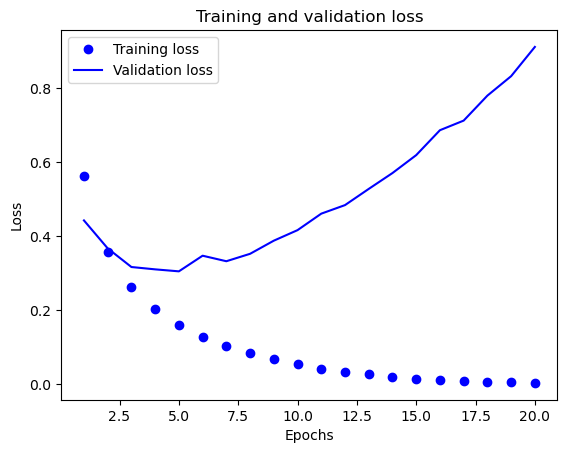

In [73]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

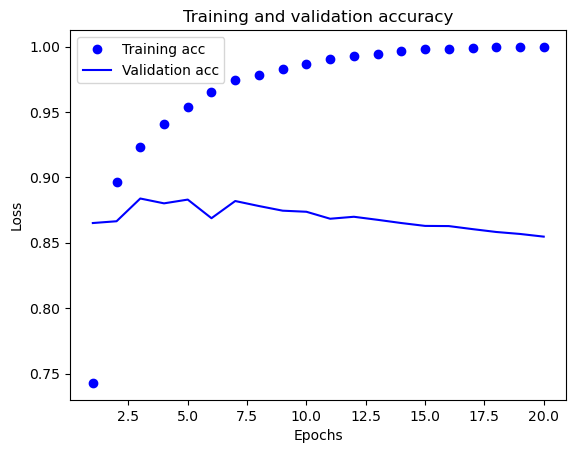

In [74]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see above, the counts are not normalized values, which is not good for the NN (neurons activations prefer normalized values, however, for Dense and Relu it makes no big difference).

However, making just unnormalized counts is the same as binary BoW, since high frequency words will dominate the vector, specially that it's very sparse, causing quick overfitting. In other words, important low freq words are discarded. This can be treated with TF-IDF, or at least by normalizing, so the network might undersand that low frequencies have special importance.

In all cases, let's try to normalize into freq and see the differene:

## Freq

In [78]:
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['label'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)
#we are using parameter stratify, to have an equal proportion of classes in train and test.

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (30450, 3) (30450,)
Test data: (13051, 3) (13051,)


In [79]:
trn_texts = normalize_corpus(X_train['preprocessed_review'])
tst_texts = normalize_corpus(X_test['preprocessed_review'])

In [80]:


# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='freq')
x_test = tok.texts_to_matrix(tst_texts, mode='freq')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)


In [81]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [82]:



model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

C:\Users\Master\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
36/36 [==============================] - 8s 82ms/step - loss: 0.6797 - binary_accuracy: 0.5742 - val_loss: 0.6684 - val_binary_accuracy: 0.5749
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.6584 - binary_accuracy: 0.5741 - val_loss: 0.6433 - val_binary_accuracy: 0.5752
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.6285 - binary_accuracy: 0.5979 - val_loss: 0.6076 - val_binary_accuracy: 0.6322
Epoch 4/20
36/36 [==============================] - 1s 23ms/step - loss: 0.5902 - binary_accuracy: 0.6887 - val_loss: 0.5651 - val_binary_accuracy: 0.7451
Epoch 5/20
36/36 [==============================] - 1s 20ms/step - loss: 0.5466 - binary_accuracy: 0.7721 - val_loss: 0.5192 - val_binary_accuracy: 0.7882
Epoch 6/20
36/36 [==============================] - 1s 21ms/step - loss: 0.5001 - binary_accuracy: 0.8228 - val_loss: 0.4716 - val_binary_accuracy: 0.8332
Epoch 7/20
36/36 [==============================] - 1s 21ms/step - los

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

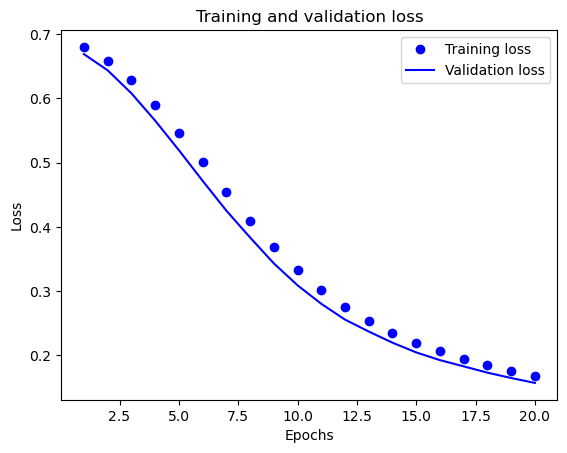

In [84]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

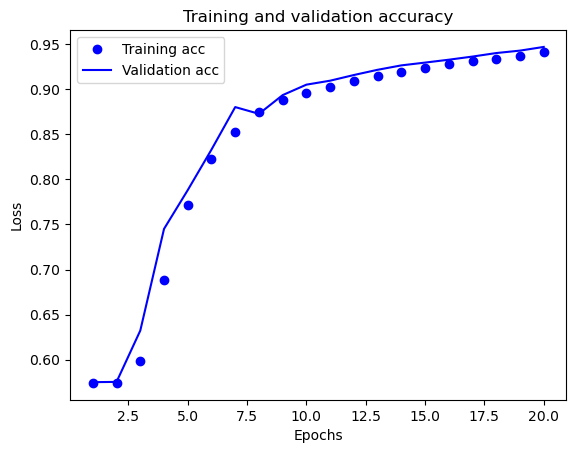

In [85]:

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, normalizing the counts correctly has a good effect to delay the overfitting. Even at the max epoch, we got higher acc (88%)

### TF-IDF features

In [88]:
from sklearn.model_selection import train_test_split

data = df.copy()
y = data['label'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)
#we are using parameter stratify, to have an equal proportion of classes in train and test.

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (30450, 3) (30450,)
Test data: (13051, 3) (13051,)


In [89]:
trn_texts = X_train['preprocessed_review']
tst_texts = X_test['preprocessed_review']

In [90]:
'''
trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)
'''
# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='tfidf')
x_test = tok.texts_to_matrix(tst_texts, mode='tfidf')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [91]:

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

C:\Users\Master\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
36/36 [==============================] - 9s 58ms/step - loss: 0.4403 - binary_accuracy: 0.8077 - val_loss: 0.3266 - val_binary_accuracy: 0.8764
Epoch 2/20
36/36 [==============================] - 1s 29ms/step - loss: 0.2221 - binary_accuracy: 0.9240 - val_loss: 0.3148 - val_binary_accuracy: 0.8725
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.1504 - binary_accuracy: 0.9503 - val_loss: 0.3180 - val_binary_accuracy: 0.8774
Epoch 4/20
36/36 [==============================] - 1s 22ms/step - loss: 0.1060 - binary_accuracy: 0.9664 - val_loss: 0.3563 - val_binary_accuracy: 0.8727
Epoch 5/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0760 - binary_accuracy: 0.9771 - val_loss: 0.4048 - val_binary_accuracy: 0.8708
Epoch 6/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0550 - binary_accuracy: 0.9847 - val_loss: 0.4664 - val_binary_accuracy: 0.8623
Epoch 7/20
36/36 [==============================] - 1s 22ms/step - los

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

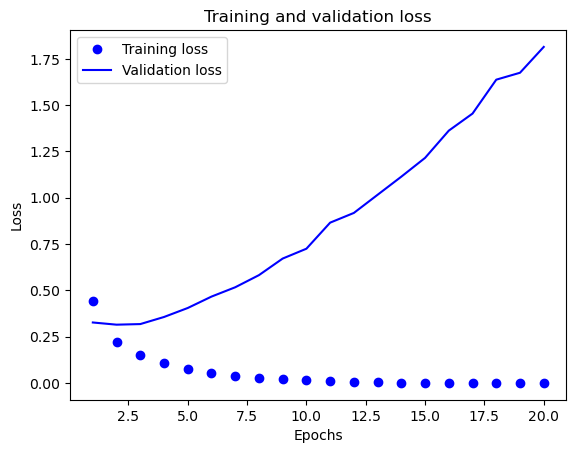

In [93]:

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

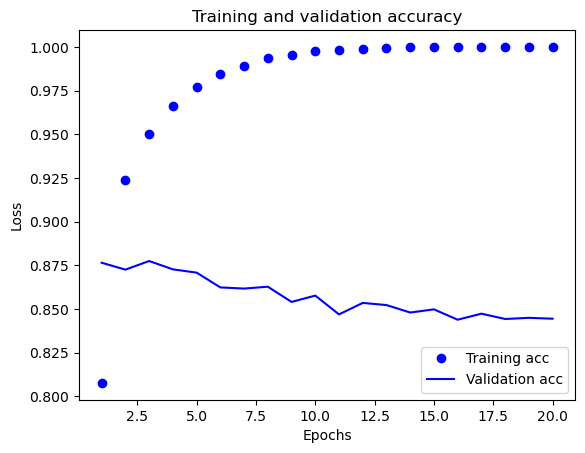

In [94]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

__TF-IDF not normalized?__

In the above setting, TFIDF in keras texts_to_matrix produce non normalized values. This is because the IDF ~= 1/DF, but log(1+DF) (for math convenience the log is calculated): http://www.tfidf.com/

https://github.com/keras-team/keras/issues/2974

For this bug, it's better to use sklearn TfidfVectorizer

__Using sklearn TfidfVectorizer__
